In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [203]:
vdf = pd.read_csv('/Users/willmayer/Desktop/DS3001/project/DS3001-Final-Project/data/voting_VA.csv', low_memory=False)

path = '/Users/willmayer/Desktop/DS3001/project/DS3001-Final-Project/data/county_data/utf8_justVA'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

dfs = {}
for file in csv_files:
    file_path = os.path.join(path, file)
    dfs[file] = pd.read_csv(file_path)

x = dfs.keys()
print(x)

# df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS')
# df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
# del gdf, cdf

dict_keys(['0002_ds206_20145_county_E.csv', '0002_ds239_20185_county_E.csv', '0002_ds249_20205_county_E.csv', '0002_ds176_20105_county_E.csv', '0002_ds191_20125_county_E.csv'])


In [204]:
dfs['0002_ds206_20145_county_E.csv']['YEAR'] = 2012
dfs['0002_ds239_20185_county_E.csv']['YEAR'] = 2016
dfs['0002_ds249_20205_county_E.csv']['YEAR'] = 2020
dfs['0002_ds176_20105_county_E.csv']['YEAR'] = 2008

In [205]:
df2020 = vdf.loc[vdf['year']==2020,:]
# df20 = df2020[::4]
df2020 = df2020.reset_index(drop=True)  # Reset index to ensure consistent grouping
df2020['group'] = df2020.index // 3     # Create a group identifier every 3 rows

# # Dynamically create an aggregation dictionary
# # Use 'first' for all columns except 'candidatevotes', which should be summed
agg_dict = {col: 'first' for col in df2020.columns if col != 'candidatevotes'}
agg_dict['candidatevotes'] = 'sum'  # Summing only the 'candidatevotes' column

# # Group by the 'group' and apply the aggregation
df_collapsed = df2020.groupby('group').agg(agg_dict).reset_index(drop=True)

# # Drop the 'group' column if no longer needed
df_collapsed.drop(columns=['group'], inplace=True, errors='ignore')

In [206]:
vdf_filtered = vdf[vdf['year'] != 2020]
vdf = pd.concat([vdf_filtered, df_collapsed], ignore_index=True)
vdf['mode'] = 'TOTAL'

In [207]:
def winner(row):
    votes = {'d': row['dvotes'], 'r': row['rvotes'], 'i': row['ivotes']}
    return max(votes, key=votes.get)  # Return the key with the highest value
def margin(row):
    votes = sorted([row['dvotes'], row['rvotes'], row['ivotes']], reverse=True)
    return votes[0] - votes[1]  # Margin is the difference between highest and second-highest

In [208]:
df_dem = vdf[vdf['party']=='DEMOCRAT']
df_rep = vdf[vdf['party']=='REPUBLICAN']
df_other = vdf[vdf['party']=='OTHER']
df_dem_sum = df_dem.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='dvotes')
df_rep_sum = df_rep.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='rvotes')
df_other_sum = df_other.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='ivotes')
df_votes = pd.merge(df_dem_sum, df_rep_sum, on=['county_fips', 'year'], how='outer')
df_votes = pd.merge(df_votes, df_other_sum, on=['county_fips','year'],how='outer')

In [209]:
stacked_r = pd.concat(dfs.values(),ignore_index=True)
stacked_r.rename(columns={'YEAR':'year','COUNTYA':'county_fips'}, inplace=True)
df_votes['county_fips'] = df_votes['county_fips'] - 51000
df_votes = pd.merge(df_votes, stacked_r, on=['county_fips', 'year'], how='left')

In [210]:
order = ['county_fips','year']
others = [x for x in stacked_r.columns if x not in order]
stacked_r = stacked_r.loc[:, order + others]

In [211]:
# df_votes = df_votes.drop_duplicates(subset=['county_fips', 'year'])

In [212]:
df_votes['winner'] = df_votes.apply(winner, axis=1)
df_votes['margin'] = df_votes.apply(margin, axis=1)

In [213]:
def rdummy(row):
    if row['winner'] == 'r':
        return 1
    else: return 0

In [215]:
df_votes['rdummy'] = df_votes.apply(rdummy, axis=1)

In [216]:
order = ['county_fips', 'year', 'winner', 'margin', 'dvotes', 'rvotes', 'ivotes', 'COUNTY', 'rdummy']
others = [x for x in df_votes.columns if x not in order]
df = df_votes.loc[:, order + others]
# df = df.dropna(axis=1)

*Plots*

Text(0.5, 1.0, 'Median annual household income by county. X=1 means county voted Republican')

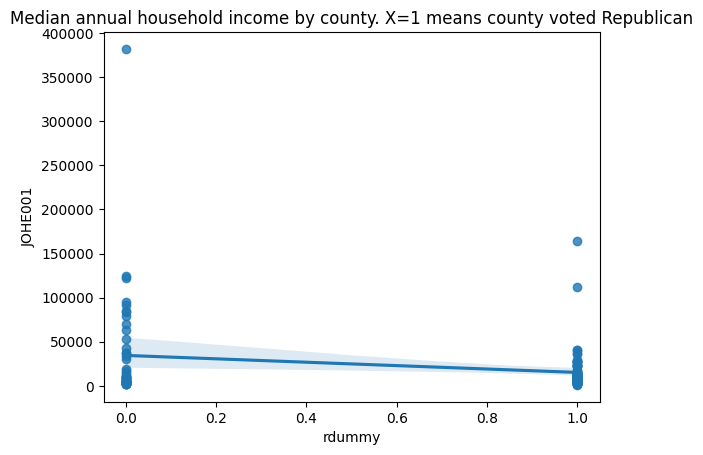

In [223]:
x = df['rdummy']
y = df['JOHE001']
sns.regplot(data=df, x='rdummy', y='JOHE001')
plt.title('Median annual household income by county. X=1 means county voted Republican')

Text(0.5, 1.0, 'Democrats win counties by larger margins')

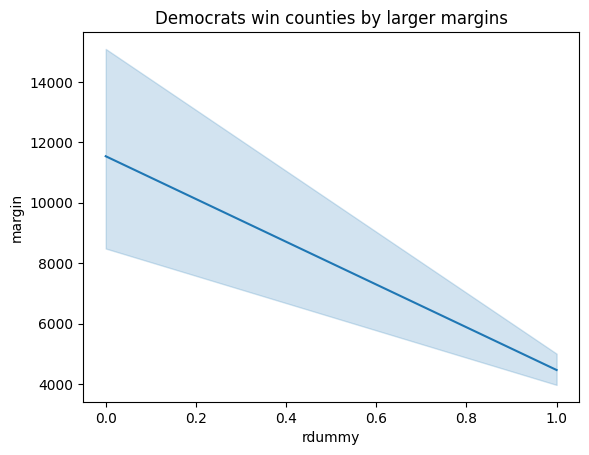

In [222]:
sns.lineplot(df, x='rdummy', y='margin')
plt.title('Democrats win counties by larger margins')